In [1]:
import pandas as pd
import tensorflow as tf
import wave
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import python_speech_features as psf

from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram
from tqdm import tqdm

%matplotlib inline

In [2]:
DATA_PATH = '/home/yvolkov/IFMO/pcmi/speech_ds'
UNKNOWN_WORD = 'UNKNOWN'
NUM_CLASSES = 3

# Data preview

In [25]:
#random wav

w_read = wave.open( os.path.join(DATA_PATH, 'eight', 
                                 '61e50f62_nohash_0.wav'))

print(w_read.getnchannels())
print(w_read.getnframes())
print(w_read.getparams())
print(w_read.getsampwidth())
print(w_read.getnframes() / w_read.getframerate())
w_bytes = w_read.readframes(w_read.getnframes())
frames = np.fromstring(w_bytes, dtype=np.int16)

1
16000
_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=16000, comptype='NONE', compname='not compressed')
2
1.0


/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


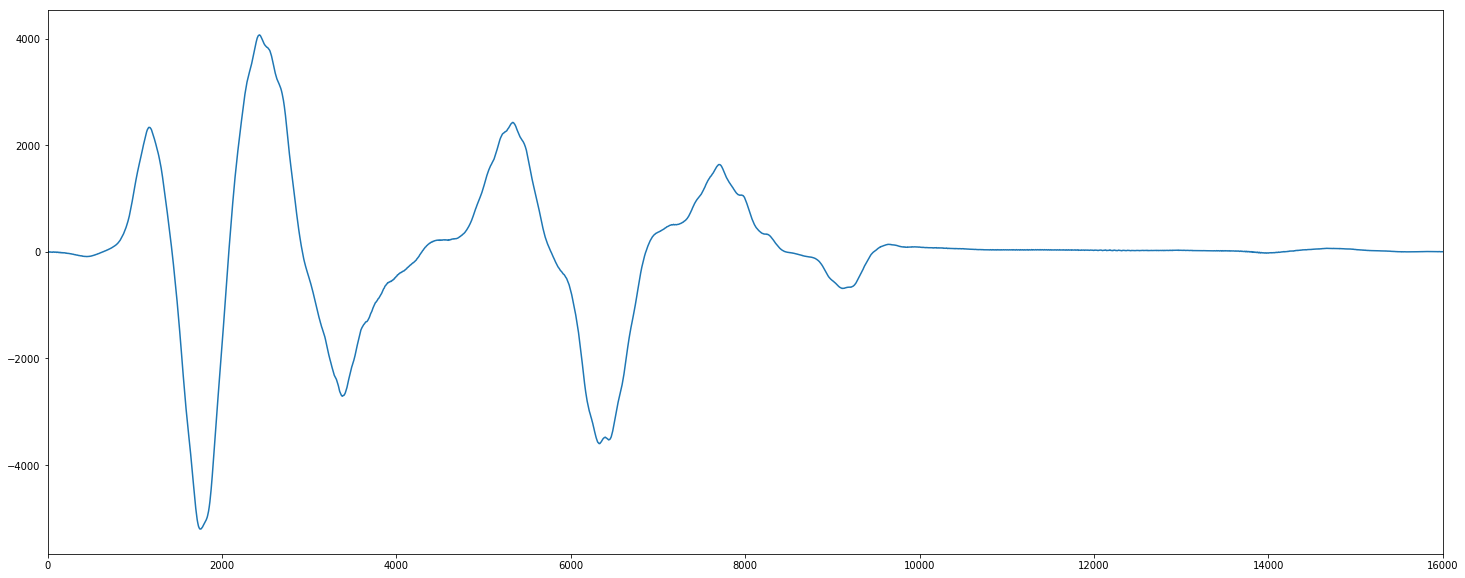

In [26]:
#Usual amplitude plot

plt.figure(figsize=(25, 10))
sns.tsplot(frames)

(129,) (71,) (129, 71)


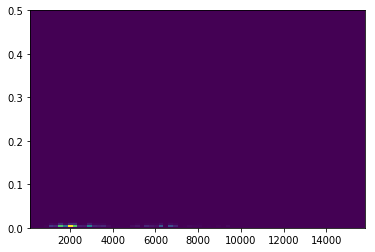

In [28]:
#Build spectrogram of signal

f, t, Sxx = spectrogram(frames)
print(f.shape, t.shape, Sxx.shape)
plt.pcolormesh(t, f, Sxx)

(99, 13)


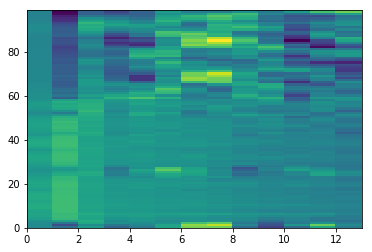

In [29]:
#Applying mfcc transform to initial recors
mfcc_frame = psf.mfcc(frames)
print(mfcc_frame.shape)
plt.pcolormesh(mfcc_frame)

# Data preparation

## Functions

In [78]:
def wav2mfcc(path):
    """
        Compute MFCC features for WAV file 
        uploaded from `path`.
        
        :param path: str
        
        :return: numpy array
            Array with shape (None, None)
    """
    
    wav_read = wave.open(path)
    params = wav_read.getparams()

    if (params.nchannels != 1) or (params.sampwidth != 2):
        raise ValueError('Incorrect input audio.')
    
    wav_bytes = wav_read.readframes(params.nframes)
    wav_amplitudes = np.fromstring(wav_bytes, dtype=np.int16)

    #Make len of each signal equal
    signal = list(wav_amplitudes)
    if len(signal) < 16000:
        signal += [0] * (16000 - len(signal))
    
    wav_mfcc = psf.mfcc(np.array(signal))
    
    return wav_mfcc

class AudioPreprocessor:
    
    def __init__(self, data_path, target_words, 
                 noise_words, test_size, batch_size=64):
        self.data_path = data_path
        self.target_words = target_words
        self.noise_words = noise_words
        self.test_size = test_size
        self.batch_size = batch_size
        
        self.word2label = {i: self.target_words.index(i)
                           for i in self.target_words}
        self.word2label[UNKNOWN_WORD] = len(self.target_words)
        
        self._split_data_()
        
    def gen_train_batch(self):
        for i in range(0, 
                       len(self.X_train) - self.batch_size,
                       self.batch_size):
            yield {'X': list(map(wav2mfcc, self.X_train[i:i+self.batch_size])),
                   'y': self.y_train[i:i+self.batch_size]}
        
    def _split_data_(self):
        X, y = [], []
        
        for word in tqdm(self.target_words):
            word_data_path = os.path.join(self.data_path, word)
            wav_names = os.listdir(word_data_path)
            
            X += list(map(lambda x: word_data_path + '/' + x, wav_names))
            y += [self.word2label[word]] * len(wav_names)
        
        for word in tqdm(self.noise_words):
            word_data_path = os.path.join(self.data_path, word)
            wav_names = os.listdir(word_data_path)
            
            X += list(map(lambda x: word_data_path + '/' + x, wav_names))
            y += [self.word2label[UNKNOWN_WORD]] * len(wav_names)
        
        (X_train, X_test, 
         y_train, y_test) = train_test_split(X, y,
                                             test_size=self.test_size,
                                             shuffle=True)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        

## Preview

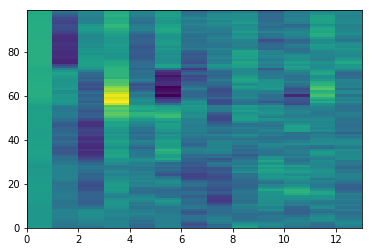

In [79]:
plt.pcolormesh(wav2mfcc(os.path.join(DATA_PATH, 'yes', 
                                 'c1d39ce8_nohash_3.wav')))

In [80]:
audio_p = AudioPreprocessor(DATA_PATH, 
                            target_words=['yes', 'no'], 
                            noise_words=['cat', 'dog'],
                            test_size=0.1)

100%|██████████| 2/2 [00:00<00:00, 299.25it/s]


In [81]:
next(audio_p.gen_train_batch())['X']

[array([[ 10.90449312, -22.86995923, -15.4288004 , ..., -14.67298015,
          17.12046805, -17.3677583 ],
        [ 11.01630846, -24.00612755, -16.93539583, ..., -25.56469901,
          13.02181143, -24.99253261],
        [ 10.94826442, -22.77250865, -14.06431065, ..., -23.03827928,
          14.89180775, -17.27166261],
        ..., 
        [ 10.25852314, -17.50213425, -18.0978136 , ..., -24.59724782,
           1.74106622,  -9.50361989],
        [ 10.08711651, -15.3205996 , -17.10233892, ..., -21.83870368,
          -4.90282309, -16.76527898],
        [  9.85816636, -14.02375609, -18.04551259, ..., -14.81639632,
           2.25613465, -13.91465549]]),
 array([[  6.49971825, -10.26202384,  -0.30341813, ...,  -4.15371031,
          -4.66494602, -13.9928105 ],
        [  6.5407091 , -10.58572436,   0.64841275, ...,  -3.18928075,
          -1.94331846,  -9.57325718],
        [  6.60049806,  -9.61262233,  -0.53543094, ..., -12.87419386,
          -4.44490996, -13.64783417],
        ...,

# Building models

## Functions

In [86]:
def w_init(shape):
    return tf.Variable(tf.truncated_normal(stddev=0.1, shape=shape))
def b_init(shape):
    return tf.Variable(tf.constant(0., shape=shape))
def conv2d(input, kernel):
    return tf.nn.conv2d(input, kernel, [1, 1, 1, 1], 'SAME')
def maxpool2d(input):
    return tf.nn.max_pool(input, [1, 2, 2, 1], [1, 1, 1, 1], 'SAME')

In [87]:
#Build graph
X_ph = tf.placeholder(tf.float32, shape=[None, None, None])
y_ph = tf.placeholder(tf.int64, shape=[None])

cnn_input = tf.stack([X_ph], axis=3)

FTRS_COUNT = 99 * 13

W1 = w_init([3, 3, 1, 32])
b1 = b_init([32])
h1 = maxpool2d(tf.nn.relu(conv2d(cnn_input, W1) + b1))

W2 = w_init([3, 3, 32, 64])
b2 = b_init([64])
h2 = maxpool2d(tf.nn.relu(conv2d(h1, W2) + b2))

h2 = tf.reshape(h2, shape=[-1, FTRS_COUNT * 64])
W3 = w_init([FTRS_COUNT * 64, NUM_CLASSES])
b3 = b_init([NUM_CLASSES])
h3 = tf.matmul(h2, W3) + b3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_ph,
                                                               logits=h3)
train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
accuracy = (tf.reduce_mean(
            tf.cast(
            tf.equal(
            tf.arg_max(h3, 1),  y_ph), tf.float32)))

In [88]:
audio_p = AudioPreprocessor(DATA_PATH, 
                            target_words=['yes', 'no'], 
                            noise_words=['cat', 'dog'],
                            test_size=0.1)

100%|██████████| 2/2 [00:00<00:00, 305.90it/s]


In [ ]:
NUM_EPOCHS = 1

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch_i in range(NUM_EPOCHS):
        for batch in audio_p.gen_train_batch():
            _accuracy_, _ = sess.run([accuracy, train_step],
                                     feed_dict={X_ph: batch['X'],
                                                y_ph: batch['y']})
            print(_accuracy_)


0.4375
0.25
0.421875
0.375
0.296875
0.265625
0.5
0.609375
0.59375
0.65625
0.46875
0.5
0.5
0.65625
0.640625
0.609375
0.625
0.59375
0.65625
0.46875
0.625
0.703125
0.703125
0.609375
0.640625
0.5625
0.515625
